In [1]:
from pathlib import Path
from time import time
import datetime
import pandas_datareader.data as web
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
pd.set_option('display.expand_frame_repr', False)
sns.set_style('darkgrid')
np.random.seed(42)

## Load Data

### Return Predictions

In [3]:
DATA_DIR = Path('..', 'data')

In [6]:
data = pd.read_hdf('00_data/backtest.h5', 'data')
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 223593 entries, ('AAL', Timestamp('2014-06-23 00:00:00')) to ('ZTS', Timestamp('2017-11-30 00:00:00'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   predicted  85657 non-null   float64
 1   open       223593 non-null  float64
 2   high       223593 non-null  float64
 3   low        223593 non-null  float64
 4   close      223593 non-null  float64
 5   volume     223593 non-null  float64
dtypes: float64(6)
memory usage: 12.0+ MB


### SP500 Benchmark

In [7]:
sp500 = web.DataReader('SP500', 'fred', '2014', '2018').pct_change()

In [8]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1044 entries, 2014-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SP500   1042 non-null   float64
dtypes: float64(1)
memory usage: 16.3 KB


## Compute Forward Returns

In [9]:
daily_returns = data.open.unstack('ticker').sort_index().pct_change()
daily_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 869 entries, 2014-06-23 to 2017-11-30
Columns: 261 entries, AAL to ZTS
dtypes: float64(261)
memory usage: 1.7 MB


In [10]:
fwd_returns = daily_returns.shift(-1)

## Generate Signals

In [11]:
predictions = data.predicted.unstack('ticker')
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 869 entries, 2014-06-23 to 2017-04-14
Columns: 261 entries, AAL to ZTS
dtypes: float64(261)
memory usage: 1.7 MB


In [12]:
long_signals = (predictions.where(predictions>0).rank(axis=1, ascending=False) > 10).astype(int)
short_signals = (predictions.where(predictions<0).rank(axis=1) > 10).astype(int)

## Compute Portfolio Returns

In [13]:
long_returns = long_signals.mul(fwd_returns).mean(axis=1)
short_returns = short_signals.mul(-fwd_returns).mean(axis=1)
strategy = long_returns.add(short_returns).to_frame('Strategy')

## Plot results

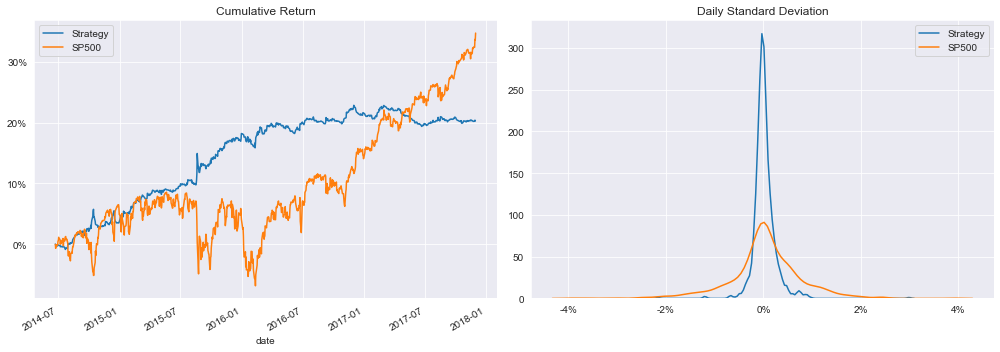

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
strategy.join(sp500).add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
sns.distplot(strategy.dropna(), ax=axes[1], hist=False, label='Strategy')
sns.distplot(sp500, ax=axes[1], hist=False, label='SP500')
axes[1].set_title('Daily Standard Deviation')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
fig.tight_layout()
fig.savefig('figures/vectorized_backtest', dpi=200);

In [15]:
res = strategy.join(sp500).dropna()

In [16]:
res.std()

Strategy    0.002409
SP500       0.007784
dtype: float64

In [17]:
res.corr()

,Strategy,SP500
Strategy,1.0000,-0.1443
SP500,-0.1443,1.0000
